# Gathering seeing data

I had some discussions with [Miguel Rodríguez Alarcon (IAC)](https://scholar.google.com/citations?user=ySJtt44AAAAJ&hl=es&oi=ao) to discuss the best way to measure and keep track of seeing. 
* He discouraged me from using from using FWHM from images, as this parameter will combine astronomical seeing effects with instrumental seeing. 
* He suggested using the DIMM sensors available throughout the institute. 
* He suggested the idea of observing if variability in DIMM seeing is directly translated into higher FWHM in the images and, therefore, if FWHM can be used for atmospheric-only seeing (i.e. if instrumental seeing is more or less constant).

## Sources of DIMM seeing
* ING - WHTR2D2, accessible via <https://astro.ing.iac.es/seeing/r2d2_data.php>
* TNG - FGC-DIMM, I don't find access to raw data via web.

### Gathering data from R2D2

In [1]:
from aspred.connector import r2d2_seeing
from datetime import datetime
import pandas as pd

initial_date = datetime(2024, 1, 1)
final_date = datetime(2024, 6, 28)

df = r2d2_seeing(initial_date, final_date)

Fetching data from https://astro.ing.iac.es/seeing/r2d2_data.php?date1=2024-01-01&date2=2024-06-28&submit=Submit...
Data retrieved successfully


<Axes: ylabel='Density'>

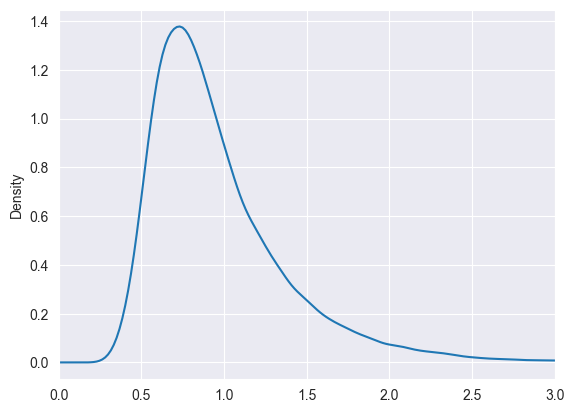

In [2]:
df["Seeing"].plot.kde(xlim=(0, 3))

* Question 1: what's the relation between the calibrated seeing during the photometric pipeline (FWHM), and the DIMM-measured seeing?
* Question 2: how close are TNG and ING seeing measurements?
* Question 3: how can the seeing be predicted from weather data?

## Getting data from LT headers

In [5]:
from aspred.connector import query_from_lt_header
import aspred.utils
import datetime

# Initial date

initial_date_mjd = aspred.utils.datetime_to_mjd(initial_date)
final_date_mjd = aspred.utils.datetime_to_mjd(final_date)

query = """SELECT mjd, AGFWHM, L1SEESEC FROM allkeys WHERE INSTRUME = "IO:O" AND AGFWHM != 0 AND mjd > """ + str(initial_date_mjd) + " AND mjd < " + str(final_date_mjd) + " ORDER BY mjd ASC"
df2 = query_from_lt_header(query)
df2["date"] = df2["mjd"].apply(aspred.utils.mjd_to_datetime)

print(len(df2), "rows")

15899 rows


/Users/fabarzuza/Documents/GitHub/aspred/aspred/connector.py:162: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dataframe = pd.read_sql(query, mydb)


In [4]:
df2

mjd  AGFWHM   L1SEESEC                       date
0      60310.005234   2.063    1.37555 2024-01-01 00:07:32.217600
1      60310.005756   2.063    1.13058 2024-01-01 00:08:17.318400
2      60310.006292   2.063    1.51499 2024-01-01 00:09:03.628800
3      60310.007329   2.063    1.45452 2024-01-01 00:10:33.225600
4      60310.007816   2.063    1.22453 2024-01-01 00:11:15.302400
...             ...     ...        ...                        ...
15894  60424.234737   2.694  999.00000 2024-04-24 05:38:01.276800
15895  60424.240471   2.694  999.00000 2024-04-24 05:46:16.694400
15896  60424.240801   2.694  999.00000 2024-04-24 05:46:45.206400
15897  60424.241203   2.694  999.00000 2024-04-24 05:47:19.939200
15898  60424.241533   2.694  999.00000 2024-04-24 05:47:48.451200

[15899 rows x 4 columns]

In [6]:
# Remove outliers with FWHM > 2
limit = 6
df2 = df2[df2["L1SEESEC"] < limit]
df = df[df["Seeing"] < limit]

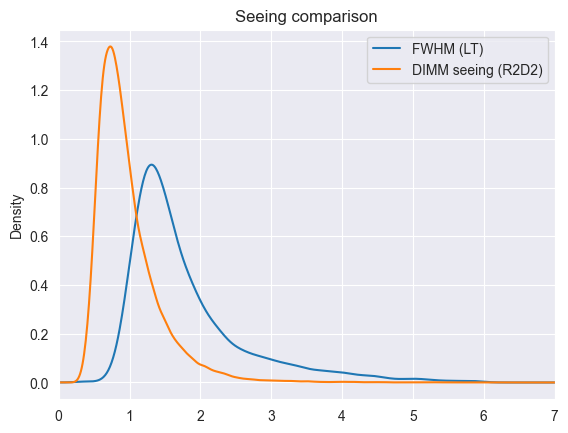

In [7]:
import matplotlib.pyplot as plt
df2["L1SEESEC"].plot.kde(xlim=(0, limit+1), label="FWHM (LT)")
df["Seeing"].plot.kde(xlim=(0, limit+1), label="DIMM seeing (R2D2)")
plt.title("Seeing comparison")
plt.legend()

In [8]:
# Creates a dataframe with 10 minute intervals from the initial date to the last date
date_range = pd.date_range(start=initial_date, end=final_date, freq="10min")

In [9]:
r2d2_list = []
fwhm_list = []
date_list = []

# Loop through the date range and calculate the average seeing (R2D2 and FWHM) for each interval
for i, date in enumerate(date_range):
    print(i, "out of ", len(date_range), end="\r")
    # Add exception for last date
    if i == len(date_range) - 1:
        continue
    # Find r2d2 seeing between this date and the next one
    r2d2_seeing = df[(df["Date"] >= date) & (df["Date"] < date_range[i+1])]["Seeing"]
    # Calculate average seeing for that interval
    r2d2_seeing_mean = r2d2_seeing.mean()
    # Find FWHM between this date and the next one
    fwhm = df2[(df2["date"] >= date) & (df2["date"] < date_range[i+1])]["L1SEESEC"]
    # Calculate average FWHM for that interval
    fwhm_mean = fwhm.mean()
    # Append to the lists
    r2d2_list.append(r2d2_seeing_mean)
    fwhm_list.append(fwhm_mean)
    date_list.append(date)
    

In [10]:
# Create dataframe with lists
df3 = pd.DataFrame({"date": date_list, "r2d2_seeing": r2d2_list, "fwhm_seeing": fwhm_list})
# Remove any rows that contains NaN in either column
df3 = df3.dropna()

Text(0.5, 1.0, 'Seeing comparison')

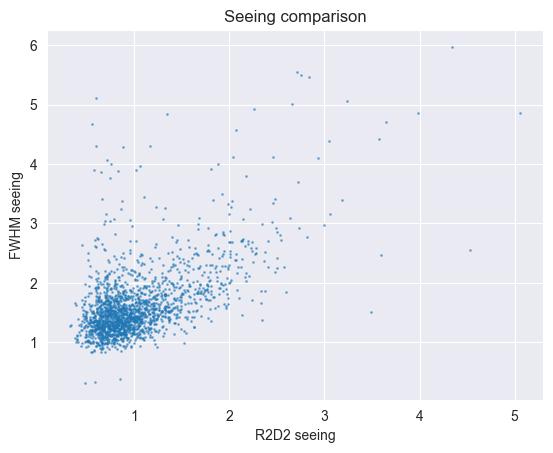

In [11]:
#Plot r2d2 seeing vs FWHM seeing
plt.scatter(df3["r2d2_seeing"], df3["fwhm_seeing"], alpha=0.5, s=1)
plt.xlabel("R2D2 seeing")
plt.ylabel("FWHM seeing")
plt.title("Seeing comparison")

In [12]:
# Find and assess correlation and linear fit
import numpy as np
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(df3["r2d2_seeing"], df3["fwhm_seeing"])
print("Slope:", slope)
print("Intercept:", intercept)
print("R value:", r_value)
print("P value:", p_value)
print("Standard error:", std_err)




Slope: 0.7197119823543648
Intercept: 0.8901236642458032
R value: 0.5828441320474368
P value: 4.899290767721779e-172
Standard error: 0.023117140329391647


Text(0.5, 1.0, 'Seeing comparison')

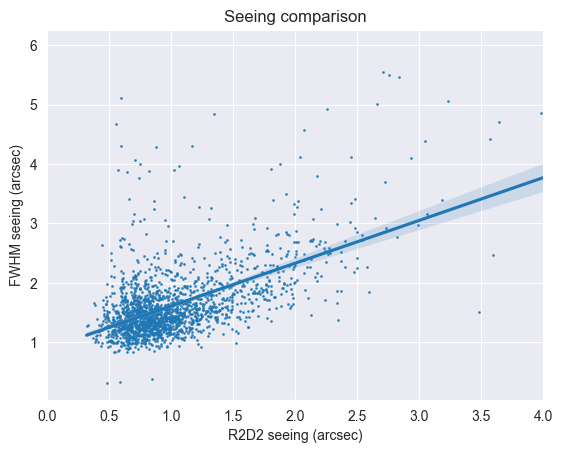

In [13]:
# Plot r2d2 seeing vs FWHM seeing with correlation line
import seaborn as sns
sns.regplot(x="r2d2_seeing", y="fwhm_seeing", data=df3, scatter_kws={"s": 1})
plt.xlim(0,4)
plt.xlabel("R2D2 seeing (arcsec)")
plt.ylabel("FWHM seeing (arcsec)")
plt.title("Seeing comparison")

Conclusion: there is no relation between the seeing measured by the DIMM sensor and the seeing measured by the FWHM in the images.


# Predicting seeing

In [1]:
#Fetch NRT data from InfluxDB
from influxdb_client import InfluxDBClient
import pandas as pd
host = 'https://influxdb.services.newrobotictelescope.org'
username = "nrt-admin"
password = "super_secret_password"
ssl = True
verify_ssl = True
token = "YNZ0oOiejxQT62BXkLyuQfTvH8su0ki9oMbv12l3VU7kwpUvk8NE_SSp10geFA6vKFg8TQMAd8y82tK2UtCVSg=="
org = "NRT"
bucket = "Weatherstation"

client = InfluxDBClient(host, token, org, timeout = 60000)
print('alive: %s' % client.ping())


query = """from(bucket: "Weatherstation")
|> range(start: 2024-02-07T00:00:00Z, stop: 2024-06-28T00:00:00Z)
|> filter(fn: (r) => r["_measurement"] == "weatherstation")
|> filter(fn: (r) => r["_field"] == "air_pressure" or r["_field"] == "air_temperature" or r["_field"] == "relative_humidity" or r["_field"] == "wind_direction_avg" or r["_field"] == "wind_speed_avg" or r["_field"] == "wind_speed_max")
|> aggregateWindow(every: 30m, fn: mean, createEmpty: false)
|> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
  """

query2 = """from(bucket: "Weatherstation")
|> range(start: 2024-02-07T00:00:00Z, stop: 2024-06-28T00:00:00Z)
|> filter(fn: (r) => r["_measurement"] == "weatherstation")
|> filter(fn: (r) => r["_field"] == "air_pressure" or r["_field"] == "air_temperature" or r["_field"] == "relative_humidity" or r["_field"] == "wind_direction_avg" or r["_field"] == "wind_speed_avg" or r["_field"] == "wind_speed_max")
|> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")

mean_table = |> aggregateWindow(every: 30m, fn: mean, createEmpty: false)
stddev_table = |> filter(fn: (r) => r["_field"] == "wind_speed_avg")
|> aggregateWindow(every: 30m, fn: stddev, createEmpty: false)
|> map(fn: (r) => ({ _time: r._time, _field: "wind_speed_avg_stddev", _value: r._value }))

join(tables: {mean: mean_table, stddev: stddev_table}, on: ["_time"])
|> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")"""

query3 = """
mean_table = from(bucket: "Weatherstation")
|> range(start: 2024-02-07T00:00:00Z, stop: 2024-07-03T10:00:00Z)
|> filter(fn: (r) => r["_measurement"] == "weatherstation")
|> filter(fn: (r) => r["_field"] == "air_pressure" or r["_field"] == "air_temperature" or r["_field"] == "relative_humidity" or r["_field"] == "wind_direction_avg" or r["_field"] == "wind_speed_avg" or r["_field"] == "wind_speed_max")
|> aggregateWindow(every: 30m, fn: mean, createEmpty: false)
|> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")

stddev_table = from(bucket: "Weatherstation")
|> range(start: 2024-02-07T00:00:00Z, stop: 2024-07-03T10:00:00Z)
|> filter(fn: (r) => r["_measurement"] == "weatherstation")
|> filter(fn: (r) => r["_field"] == "wind_speed_avg")
|> aggregateWindow(every: 30m, fn: stddev, createEmpty: false)
|> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")

join(tables: {mean: mean_table, stddev: stddev_table}, on: ["_time"])
|> drop(columns: ["_start", "_stop"])
"""
system_stats = client.query_api().query_data_frame(query3, org)


>>> Request: 'GET https://influxdb.services.newrobotictelescope.org/ping?'
>>> Authorization: ***
>>> User-Agent: influxdb-client-python/1.43.0
>>> Content-Type: application/json
>>> Body: None
<<< Response: 204
<<< X-Influxdb-Build: OSS
<<< X-Influxdb-Version: v2.3.0+SNAPSHOT.090f681737
<<< Date: Wed, 03 Jul 2024 14:46:45 GMT
<<< Via: 1.1 google
<<< Alt-Svc: h3=":443"; ma=2592000,h3-29=":443"; ma=2592000
<<< Body: 
alive: True
>>> Request: 'POST https://influxdb.services.newrobotictelescope.org/api/v2/query?org=NRT'
>>> Accept: application/json
>>> Content-Type: application/json
>>> Authorization: ***
>>> User-Agent: influxdb-client-python/1.43.0
>>> Body: {'extern': {'imports': [], 'body': []}, 'query': '\nmean_table = from(bucket: "Weatherstation")\n|> range(start: 2024-02-07T00:00:00Z, stop: 2024-07-03T10:00:00Z)\n|> filter(fn: (r) => r["_measurement"] == "weatherstation")\n|> filter(fn: (r) => r["_field"] == "air_pressure" or r["_field"] == "air_temperature" or r["_field"] == "rel

In [2]:
weather_data = system_stats[["_time", "air_pressure", "air_temperature", "relative_humidity", "wind_direction_avg", "wind_speed_avg_mean", "wind_speed_max", "wind_speed_avg_stddev"]]
weather_data["time"] = weather_data["_time"].dt.tz_localize(None)


/var/folders/6r/4fgw_d4j3h17pk5bq1w2dqcw0000gn/T/ipykernel_81257/987057805.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_data["time"] = weather_data["_time"].dt.tz_localize(None)


In [3]:
weather_data

_time  air_pressure  air_temperature  \
0    2024-02-07 09:00:00+00:00    778.300000         7.200000   
1    2024-02-07 09:30:00+00:00    778.372414         8.548276   
2    2024-02-07 10:00:00+00:00    778.580000         9.288000   
3    2024-02-07 10:30:00+00:00    778.580000         9.136667   
4    2024-02-07 11:00:00+00:00    778.641379         9.541379   
...                        ...           ...              ...   
7049 2024-07-03 08:00:00+00:00    776.010345        19.006897   
7050 2024-07-03 08:30:00+00:00    776.146667        19.866667   
7051 2024-07-03 09:00:00+00:00    776.241379        20.758621   
7052 2024-07-03 09:30:00+00:00    776.323333        21.593333   
7053 2024-07-03 10:00:00+00:00    776.424138        22.410345   

      relative_humidity  wind_direction_avg  wind_speed_avg_mean  \
0              8.400000          192.000000             3.000000   
1              5.127586          180.068966             3.906897   
2              5.044000          166.480000             2.744000   
3              7.533333          155.600000             3.110000   
4              9.865517          151.034483             2.720690   
...                 ...                 ...                  ...   
7049           7.462069          275.379310             2.196552   
7050           7.786667          263.833333             2.146667   
7051           7.565517          260.000000             2.024138   
7052           7.280000          258.733333             2.230000   
7053           7.517241          257.793103             1.934483   

      wind_speed_max  wind_speed_avg_stddev                time  
0           4.200000                    NaN 2024-02-07 09:00:00  
1           5.048276               0.780078 2024-02-07 09:30:00  
2           3.404000               0.501730 2024-02-07 10:00:00  
3           4.313333               0.562231 2024-02-07 10:30:00  
4           3.568966               0.581488 2024-02-07 11:00:00  
...              ...                    ...                 ...  
7049        4.558621               0.360042 2024-07-03 08:00:00  
7050        4.730000               0.341127 2024-07-03 08:30:00  
7051        4.731034               0.448533 2024-07-03 09:00:00  
7052        5.173333               0.426008 2024-07-03 09:30:00  
7053        4.641379               0.362802 2024-07-03 10:00:00  

[7054 rows x 9 columns]

In [5]:
from aspred.connector import r2d2_seeing
from datetime import datetime
initial_date = datetime(2024, 2, 7)
final_date = datetime(2024, 7, 3)
df = r2d2_seeing(initial_date, final_date)

Fetching data from https://astro.ing.iac.es/seeing/r2d2_data.php?date1=2024-02-07&date2=2024-07-03&submit=Submit...
Data retrieved successfully


In [6]:
df

Date  Seeing
0     2024-02-07 00:00:05  0.6346
1     2024-02-07 00:01:03  0.7416
2     2024-02-07 00:02:01  0.6790
3     2024-02-07 00:02:04  0.7846
4     2024-02-07 00:03:02  0.7514
...                   ...     ...
47581 2024-07-02 22:57:03  0.8190
47582 2024-07-02 22:58:01  0.7487
47583 2024-07-02 22:58:04  0.7562
47584 2024-07-02 22:59:02  0.7083
47585 2024-07-02 22:59:05  0.6681

[47586 rows x 2 columns]

In [7]:
# Add seeing into weather_data, calculating average for time intervals
import numpy as np

seeing_list = []
date_list = []
for i, date in enumerate(weather_data["time"]):
    print(i, "out of ", len(weather_data["_time"]), end="\r")
    if i == len(weather_data["_time"]) - 1:
        continue
    seeing = df[(df["Date"] >= date) & (df["Date"] < weather_data["time"][i+1])]["Seeing"]
    seeing_mean = seeing.mean()
    seeing_list.append(seeing_mean)
    date_list.append(date)

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.50385,
 0.96414,
 0.9987239999999998,
 1.049947368421053,
 1.0420210526315785,
 0.8252434782608696,
 0.9360690476190475,
 1.099463157894737,
 0.8916,
 1.15,
 0.89465,
 2.1149,
 1.2294999999999998,
 nan,
 nan,
 nan,
 nan,
 1.1907,
 1.6237,
 1.2743,
 2.3352,
 nan,
 1.4272,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.8687,
 0.9559340425531915,
 0.9504294117647059,
 0.9564749999999999,
 1.0709666666666666,
 0.882525,
 nan,
 1.6705,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,


In [8]:
# Remove last row from weather dataframe and add seeing
weather_data = weather_data[:-1]
weather_data["seeing"] = seeing_list

clean_weather_data = weather_data.dropna()

/var/folders/6r/4fgw_d4j3h17pk5bq1w2dqcw0000gn/T/ipykernel_81257/2743535150.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_data["seeing"] = seeing_list


In [9]:
clean_weather_data

_time  air_pressure  air_temperature  \
19   2024-02-07 18:30:00+00:00    776.355172        11.365517   
20   2024-02-07 19:00:00+00:00    776.196667        10.173333   
21   2024-02-07 19:30:00+00:00    776.392857         9.857143   
22   2024-02-07 20:00:00+00:00    776.533333         8.886667   
23   2024-02-07 20:30:00+00:00    776.727586         9.486207   
...                        ...           ...              ...   
7026 2024-07-02 20:30:00+00:00    776.575862        18.537931   
7027 2024-07-02 21:00:00+00:00    776.600000        18.743333   
7028 2024-07-02 21:30:00+00:00    776.744828        18.434483   
7029 2024-07-02 22:00:00+00:00    776.873333        18.576667   
7030 2024-07-02 22:30:00+00:00    776.893103        17.975862   

      relative_humidity  wind_direction_avg  wind_speed_avg_mean  \
19            12.534483          212.517241             1.493103   
20             9.230000          201.466667             1.493333   
21             6.667857          212.357143             1.692857   
22            10.860000          164.800000             2.223333   
23             6.886207          226.827586             1.527586   
...                 ...                 ...                  ...   
7026          20.465517          183.896552             2.200000   
7027           9.226667          191.366667             2.653333   
7028           9.741379          207.655172             2.941379   
7029           7.716667          197.166667             2.896667   
7030          10.693103          241.379310             2.348276   

      wind_speed_max  wind_speed_avg_stddev                time    seeing  
19          2.493103               0.620444 2024-02-07 18:30:00  0.503850  
20          2.113333               0.556425 2024-02-07 19:00:00  0.964140  
21          2.400000               0.504005 2024-02-07 19:30:00  0.998724  
22          2.760000               0.542461 2024-02-07 20:00:00  1.049947  
23          2.386207               0.483216 2024-02-07 20:30:00  1.042021  
...              ...                    ...                 ...       ...  
7026        3.075862               0.446414 2024-07-02 20:30:00  0.894405  
7027        3.886667               0.535456 2024-07-02 21:00:00  0.700315  
7028        3.896552               0.404896 2024-07-02 21:30:00  0.733584  
7029        3.823333               0.455225 2024-07-02 22:00:00  0.530035  
7030        3.103448               0.338717 2024-07-02 22:30:00  0.677569  

[1709 rows x 10 columns]

# Unsuperised learning

In [10]:
from sklearn.preprocessing import StandardScaler

# Separate features and target
X = clean_weather_data.drop(columns=['seeing', '_time', 'time'])
y = clean_weather_data['seeing']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
from sklearn.decomposition import PCA

# Reduce to 2 dimensions for visualization purposes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a new dataframe with the PCA results
df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df_pca['seeing'] = y.values


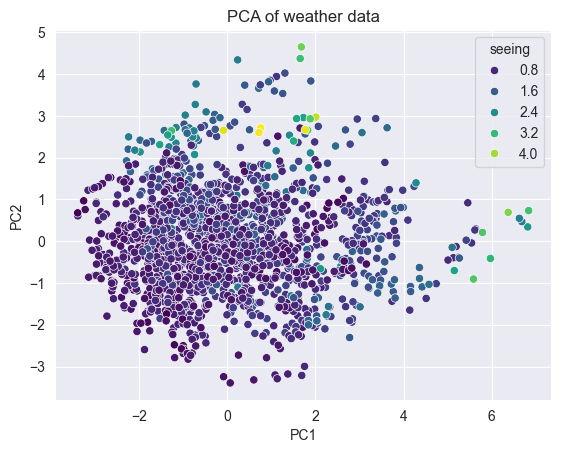

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(x='PC1', y='PC2', data=df_pca, hue='seeing', palette='viridis')
plt.title('PCA of weather data')
plt.show()


In [13]:
from sklearn.cluster import KMeans

# Choose the number of clusters
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to the dataframe
df_pca['Cluster'] = clusters


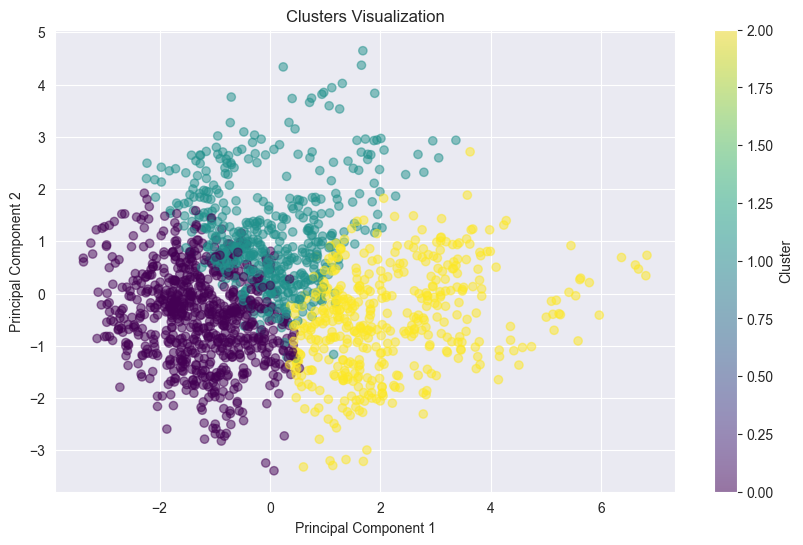

Cluster 0:
count    761.000000
mean       0.812215
std        0.270984
min        0.326967
25%        0.643470
50%        0.759350
75%        0.902900
max        2.714106
Name: seeing, dtype: float64


Cluster 1:
count    509.000000
mean       1.240162
std        0.604395
min        0.452130
25%        0.844833
50%        1.118396
75%        1.432600
max        4.584267
Name: seeing, dtype: float64


Cluster 2:
count    439.000000
mean       1.044337
std        0.479928
min        0.375253
25%        0.771135
50%        0.944313
75%        1.201596
max        4.484700
Name: seeing, dtype: float64




In [14]:
import matplotlib.pyplot as plt

# Visualize the clusters
plt.figure(figsize=(10, 6))
plt.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca['Cluster'], cmap='viridis', alpha=0.5)
plt.title('Clusters Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Analyze the distribution of "seeing" in each cluster
for cluster in df_pca['Cluster'].unique():
    cluster_data = df_pca[df_pca['Cluster'] == cluster]
    print(f'Cluster {cluster}:')
    print(cluster_data['seeing'].describe())
    print('\n')


# Supervised learning

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [16]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [17]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')


Mean Squared Error: 0.07815079611062228
R2 Score: 0.6713811093764152


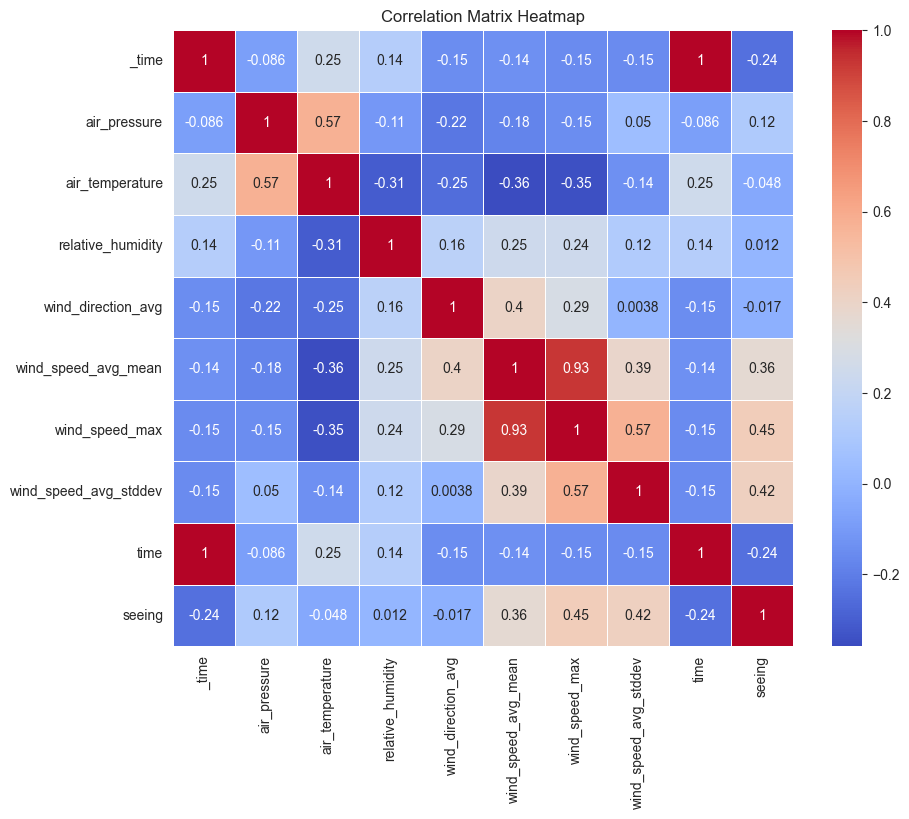

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = clean_weather_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


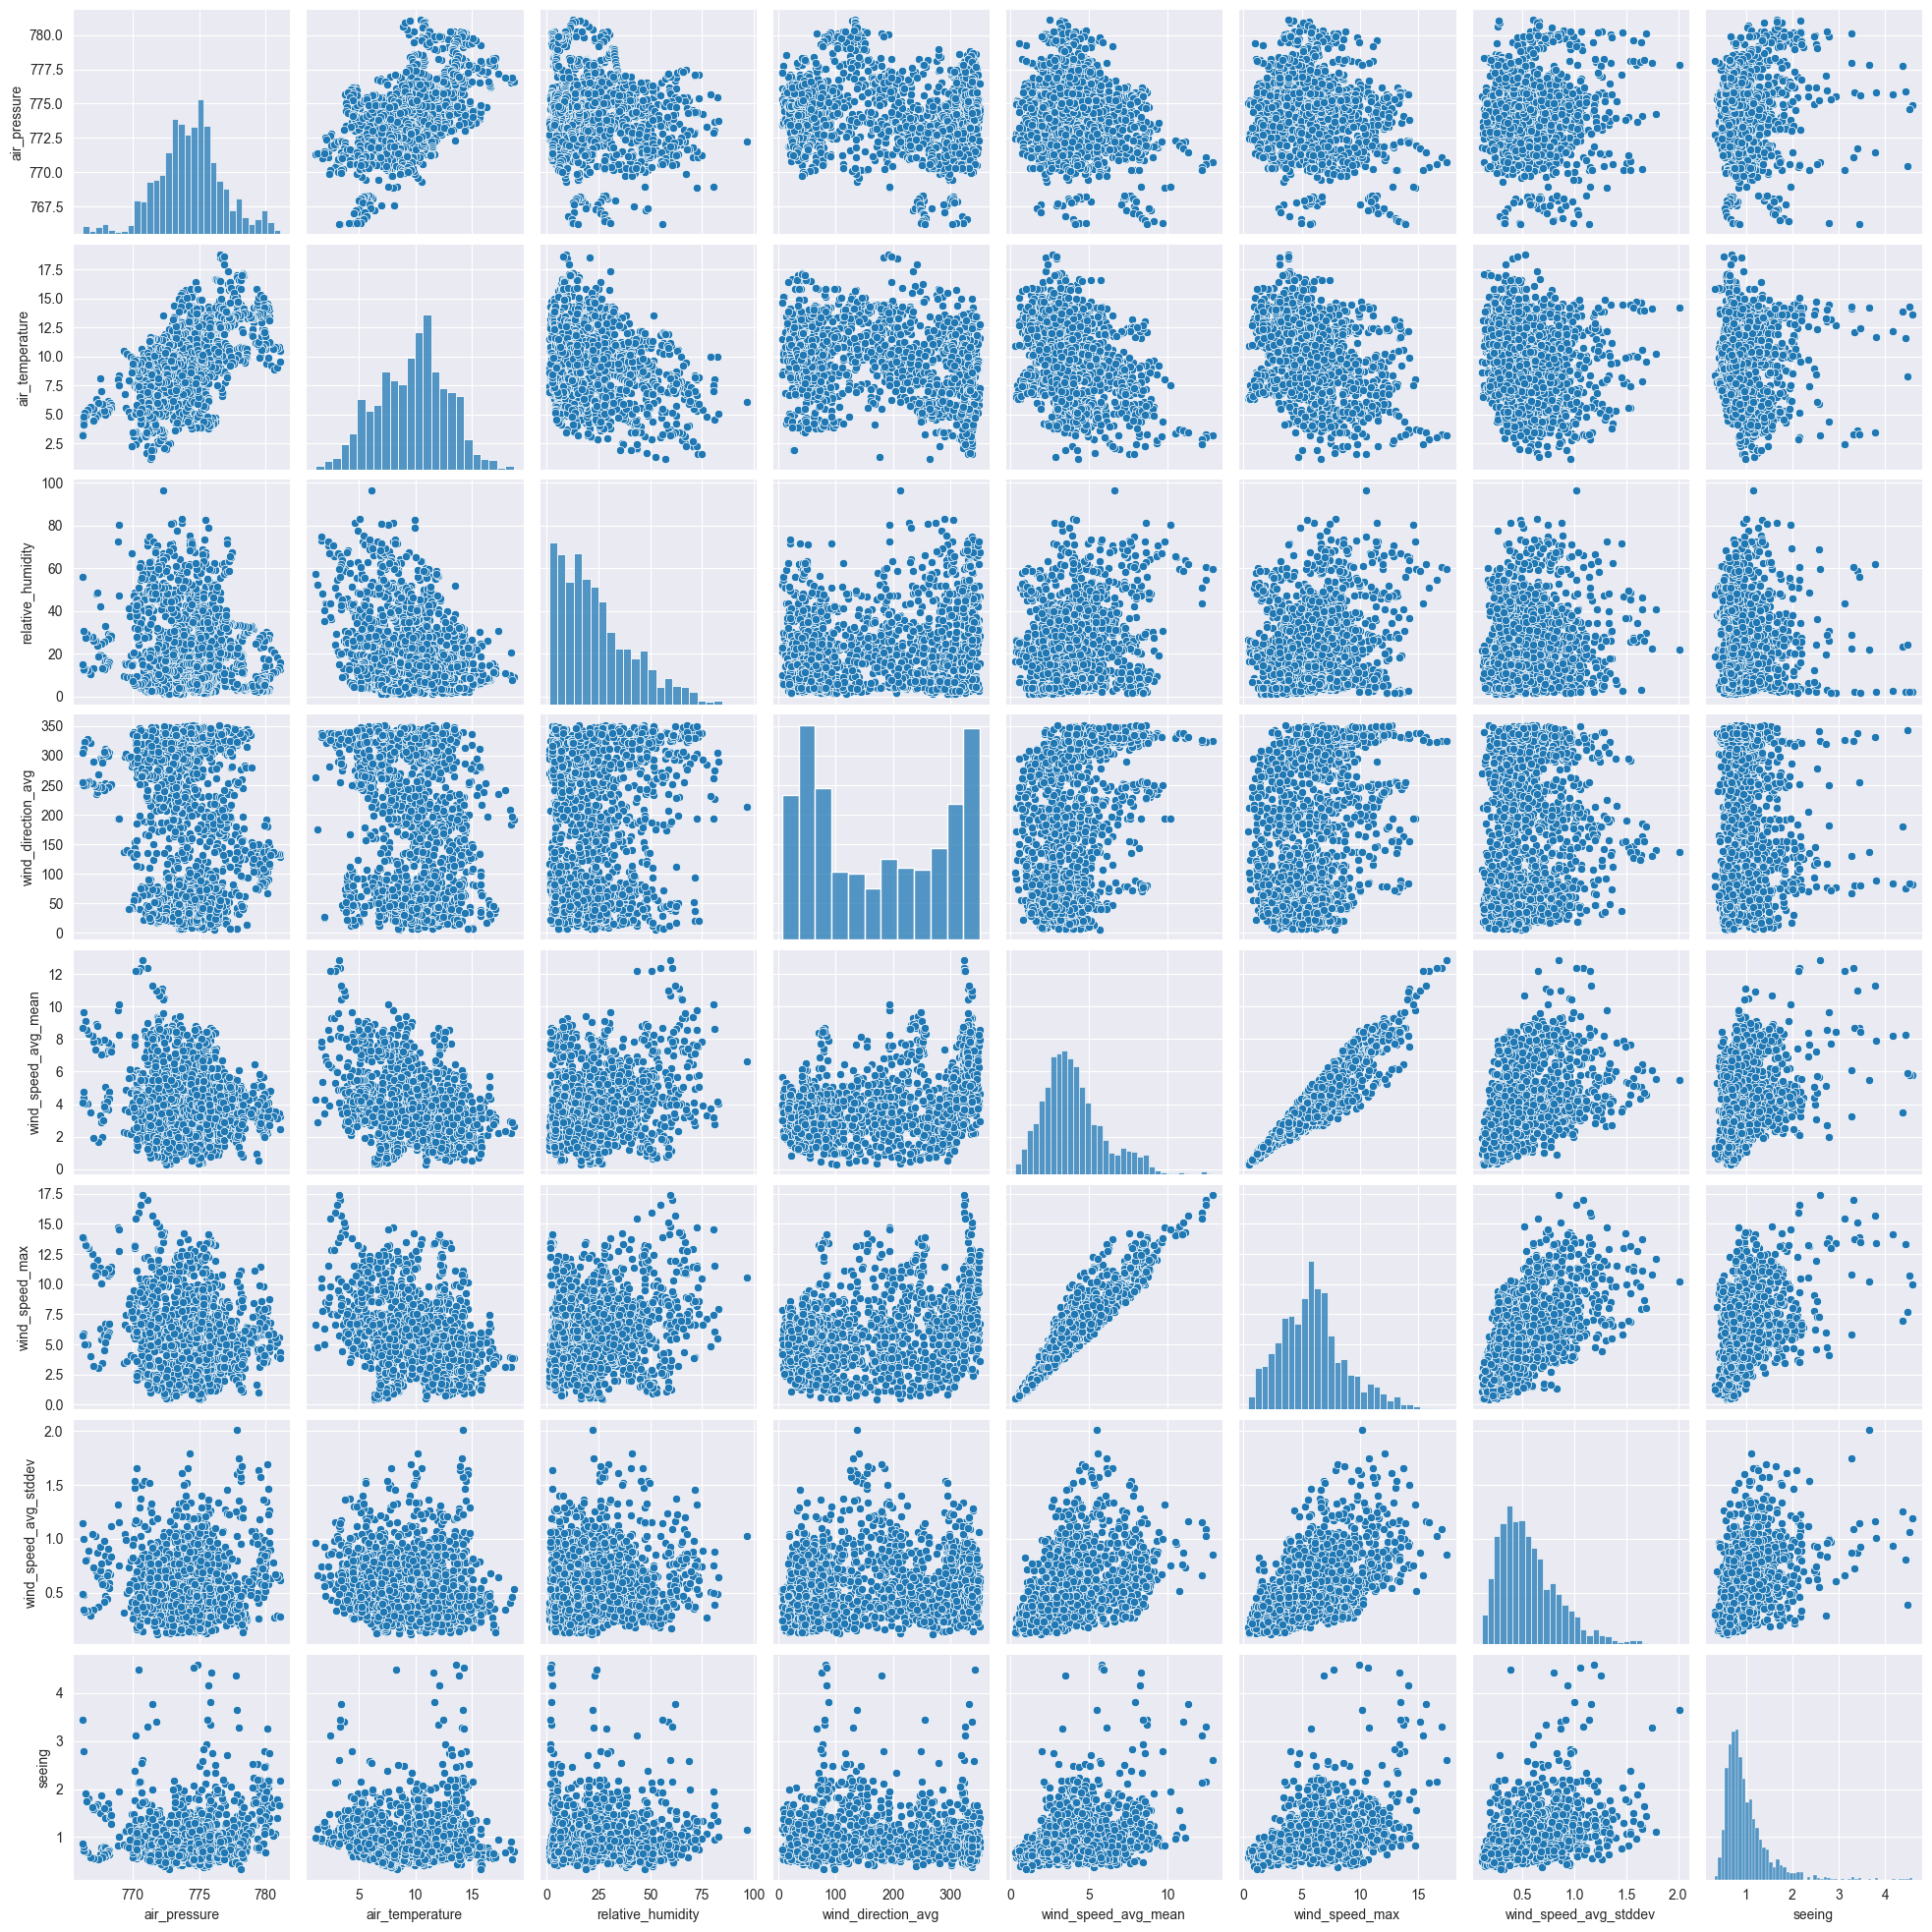

In [19]:
sns.pairplot(clean_weather_data)
plt.show()

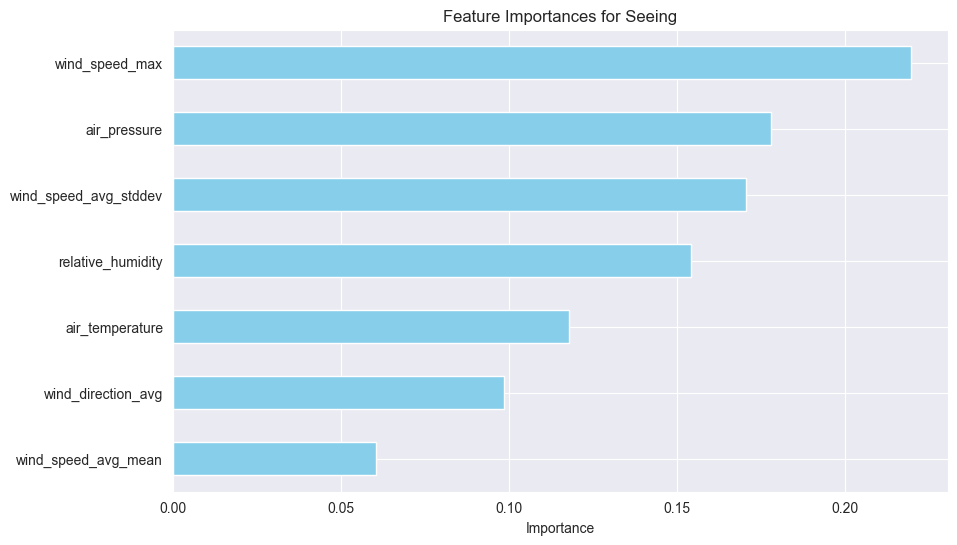

In [20]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor

# Train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_
feature_names = X.columns
feature_importances = pd.Series(importances, index=feature_names)

# Sort and plot feature importances
sorted_importances = feature_importances.sort_values()
plt.figure(figsize=(10, 6))
sorted_importances.plot(kind='barh', color='skyblue')
plt.title('Feature Importances for Seeing')
plt.xlabel('Importance')
plt.show()



In [21]:
# Create a new column with the predicted seeing
clean_weather_data['seeing_predicted'] = model.predict(X_scaled)

/var/folders/6r/4fgw_d4j3h17pk5bq1w2dqcw0000gn/T/ipykernel_81257/2529860354.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_weather_data['seeing_predicted'] = model.predict(X_scaled)


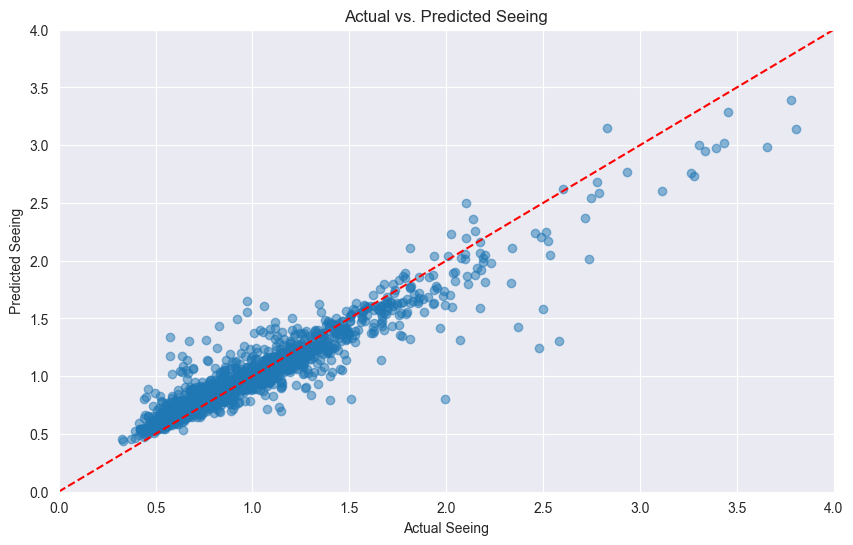

In [22]:
# Plot the actual vs. predicted seeing with linear regression, r squared, and p value
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress

plt.figure(figsize=(10, 6))
plt.scatter(clean_weather_data['seeing'], clean_weather_data['seeing_predicted'], alpha=0.5)
plt.plot([0, 4], [0, 4], color='red', linestyle='--')
plt.xlim(0, 4)
plt.ylim(0, 4)

plt.xlabel('Actual Seeing')
plt.ylabel('Predicted Seeing')
plt.title('Actual vs. Predicted Seeing')
plt.show()

In [23]:
# We print the r correlation and the p parameter
slope, intercept, r_value, p_value, std_err = linregress(clean_weather_data['seeing'], clean_weather_data['seeing_predicted'])
print("Slope:", slope)
print("Intercept:", intercept)
print("R value:", r_value)
print("P value:", p_value)
print("Standard error:", std_err)

Slope: 0.7830083751440406
Intercept: 0.21807889810067205
R value: 0.9500721574459856
P value: 0.0
Standard error: 0.006224289680399229


In [24]:
# Add the predicted seeing to the dataframe
clean_weather_data['seeing_predicted'] = model.predict(X_scaled)

/var/folders/6r/4fgw_d4j3h17pk5bq1w2dqcw0000gn/T/ipykernel_81257/2043567219.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_weather_data['seeing_predicted'] = model.predict(X_scaled)


/var/folders/6r/4fgw_d4j3h17pk5bq1w2dqcw0000gn/T/ipykernel_81257/3317343495.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_weather_data['seeing_difference'] = clean_weather_data['seeing'] - clean_weather_data['seeing_predicted']


Text(0, 0.5, 'Seeing Difference')

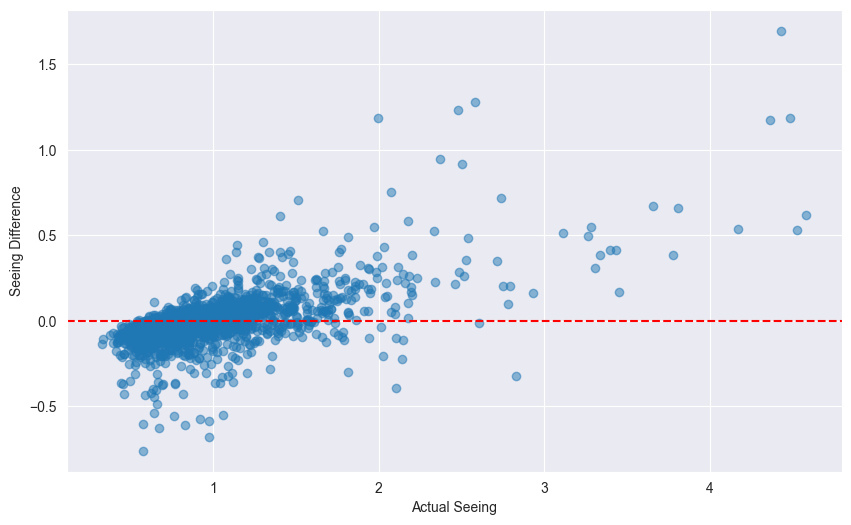

In [25]:
# Plot the difference between actual seeing and predicted seeing, in function of the actual seeing
clean_weather_data['seeing_difference'] = clean_weather_data['seeing'] - clean_weather_data['seeing_predicted']

plt.figure(figsize=(10, 6))
plt.scatter(clean_weather_data['seeing'], clean_weather_data['seeing_difference'], alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Actual Seeing")
plt.ylabel("Seeing Difference")

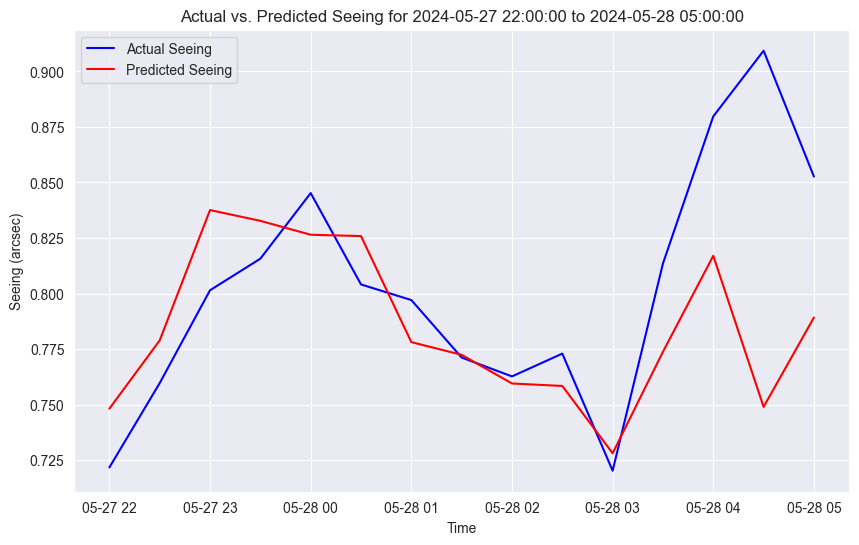

In [47]:
# Select only weather data from one specific night
# selected_night = '2024-05-27'
selected_night = datetime(2024, 5, 27)
interval_begin = selected_night.replace(hour=22, minute=0, second=0)
interval_end = selected_night.replace(hour=5, minute=0, second=0) + pd.Timedelta(days=1)


#interval_begin = '2024-05-27 22:00:00'
#interval_end = '2024-05-28 05:00:00'

selected_data = clean_weather_data[(clean_weather_data['time'] >= interval_begin) & (clean_weather_data['time'] <= interval_end)]

# Plot the actual seeing and predicted seeing for that night
plt.figure(figsize=(10, 6))
plt.plot(selected_data['time'], selected_data['seeing'], label='Actual Seeing', color='blue')
plt.plot(selected_data['time'], selected_data['seeing_predicted'], label='Predicted Seeing', color='red')
plt.xlabel('Time')
plt.ylabel('Seeing (arcsec)')
plt.title(f'Actual vs. Predicted Seeing for {interval_begin} to {interval_end}')
plt.legend()

In [34]:
selected_data

_time  air_pressure  air_temperature  \
6741 2024-06-26 22:00:00+00:00    774.396552        10.368966   
6742 2024-06-26 22:30:00+00:00    774.633333        10.383333   
6743 2024-06-26 23:00:00+00:00    774.755172        10.817241   
6744 2024-06-26 23:30:00+00:00    774.806667        11.460000   

      relative_humidity  wind_direction_avg  wind_speed_avg_mean  \
6741           6.193103          160.965517             3.965517   
6742           7.380000           56.900000             3.563333   
6743           6.655172           18.241379             4.079310   
6744           5.633333           19.366667             3.886667   

      wind_speed_max  wind_speed_avg_stddev                time    seeing  \
6741        6.634483               0.603724 2024-06-26 22:00:00  1.112624   
6742        6.096667               0.578037 2024-06-26 22:30:00  1.285524   
6743        6.675862               0.477628 2024-06-26 23:00:00  0.996520   
6744        6.433333               0.464412 2024-06-26 23:30:00  0.707500   

      seeing_predicted  seeing_difference  
6741          1.077925           0.034699  
6742          1.023726           0.261798  
6743          0.991254           0.005266  
6744          0.828987          -0.121487

In [36]:
# Try neural network instead of random forest
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=1000, random_state=42)
model.fit(X_train, y_train)



MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=1000, random_state=42)

In [37]:
# Create a new column with the predicted seeing
clean_weather_data['seeing_predicted_mplr'] = model.predict(X_scaled)

/var/folders/6r/4fgw_d4j3h17pk5bq1w2dqcw0000gn/T/ipykernel_62445/3213089333.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_weather_data['seeing_predicted_mplr'] = model.predict(X_scaled)


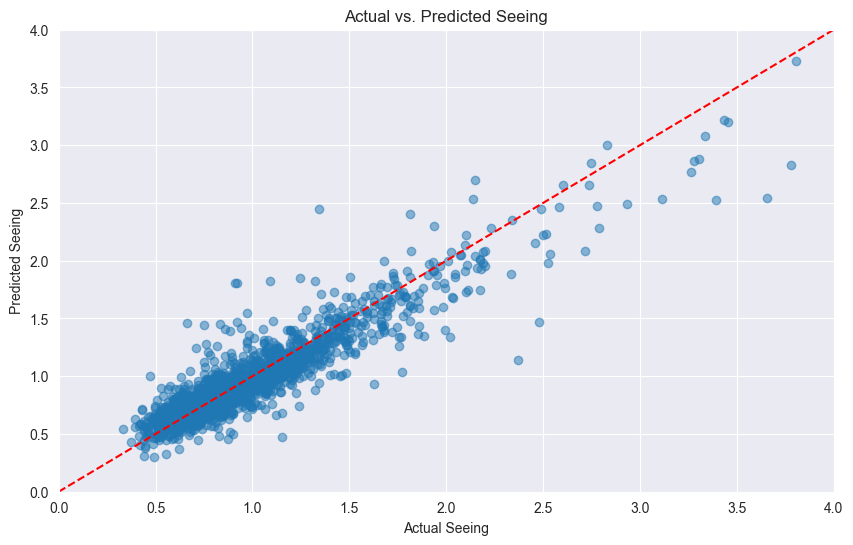

In [38]:
# Plot the actual vs. predicted seeing with linear regression, r squared, and p value

plt.figure(figsize=(10, 6))
plt.scatter(clean_weather_data['seeing'], clean_weather_data['seeing_predicted_mplr'], alpha=0.5)
plt.plot([0, 4], [0, 4], color='red', linestyle='--')
plt.xlim(0, 4)
plt.ylim(0, 4)

plt.xlabel('Actual Seeing')
plt.ylabel('Predicted Seeing')
plt.title('Actual vs. Predicted Seeing')
plt.show()


In [39]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')

Mean Squared Error: 0.06958938351009822
R2 Score: 0.6640422120761365
